# Transfer Learning with Tensorflow Part 1: Feature extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problems.  
There are two main benefits:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
1. Can leverage a working neural architecture which has already learned patterns on similar data to our own, then can adapt those patterns to our own data.

In [ ]:
# Are we using a GPU
!nvidia-smi

Fri Jun 24 17:12:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Download and becoming one with data

In [ ]:
# Get data (10% of 10 food classes from Food101)
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref=zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2022-06-24 17:12:34--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   309MB/s    in 0.5s    

2022-06-24 17:12:35 (309 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/tes

## Creating data loaders (preparing the data)

We'll use the `ImageDataGenerator` class to load in our images in batches.

In [ ]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE=(224,224)
BATCH_SIZE=32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.0)
test_datagen = ImageDataGenerator(rescale=1/255.0)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("Testing images:")
test_data_10_percent = test_datagen.flow_from_directory(test_dir,
                                                        target_size=IMAGE_SHAPE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode="categorical")


Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Settings up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add so your models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with the Tensorboard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [ ]:
# Create TensorBoard callback(functionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name,experiment_name):
  log_dir=dir_name+"/"+experiment_name+'/'+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving Tensorboard log files to: {log_dir}")
  return tensorboard_callback


> 🔑**Note:** You can customize the directory where your Tensorboard logs (model training metrics) get saved to whatever you like.  
The `log_dir` parameter we've created above is only one option.

## Creating models using Tensorflow Hub  

In the past we've used Tensorflow to create our own models layer by layer from scratch.  
Now we're going to do a similar process, except the majority of our model's layers are going to come from Tensorflow Hub.  
We can access pretrained models on: https://tfhub.dev/

Browsing the Tensorflow Hub page and sorting for image classification, we found the following feature vector model  link: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [ ]:
# Let's compare the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

efficient_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
# Import dependancies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
# Let's make a create_model() function to create a model from URL
def create_model(model_url,num_classes=10):
  """
  Takes a Tensorflow Hub URL and create a Keras Sequential model with it.

  Args:
    model_url (str): A Tensorflow Hub feature extraction URL
    num_classes (int): Number of output neurons in the output layer,
    should be equal to number of target classes, default 10.
  
  Return:
    An uncompiled Keras Sequential model with model_url as feature extractor
    layer and Dense output layer with num_classes output neurons.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,))
  
  # Create our own model
  model=tf.keras.models.Sequential(
      [
       feature_extractor_layer,
       layers.Dense(num_classes,activation="softmax",name="output_layer")
      ]
  )

  return model

### Creating ResNet Tensorflow Hub Feature Extraction model

In [ ]:
# Create ResNet model
resnet_model=create_model(resnet_url,
                          num_classes=train_data_10_percent.num_classes)

In [ ]:
# Compile our resnet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer="Adam",
                     metrics=["accuracy"])

In [ ]:
# Fit the model
history_resnet = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data_10_percent,
                                  validation_steps=len(test_data_10_percent),
                                  callbacks=[create_tensorboard_callback(dir_name="tf_hub",experiment_name="resnet50V2")])

Saving Tensorboard log files to: tf_hub/resnet50V2/20220624-171457
Epoch 1/5
24/24 [==============================] - 34s 742ms/step - loss: 1.9747 - accuracy: 0.3400 - val_loss: 1.2680 - val_accuracy: 0.6032
Epoch 2/5
24/24 [==============================] - 16s 686ms/step - loss: 0.9390 - accuracy: 0.7187 - val_loss: 0.8457 - val_accuracy: 0.7240
Epoch 3/5
24/24 [==============================] - 16s 684ms/step - loss: 0.6329 - accuracy: 0.8227 - val_loss: 0.7828 - val_accuracy: 0.7380
Epoch 4/5
24/24 [==============================] - 16s 679ms/step - loss: 0.4794 - accuracy: 0.8813 - val_loss: 0.7162 - val_accuracy: 0.7600
Epoch 5/5
24/24 [==============================] - 16s 683ms/step - loss: 0.3905 - accuracy: 0.9080 - val_loss: 0.6835 - val_accuracy: 0.7740


Wow!  
That. Is. Incredible. Our transfer learning feature extractor model outperformed ALL of the previous mdels we  built by hand... (substantially) and in a quicker training time.] AND with only 10% of the training examples.

In [ ]:
# Let's create a function to plot our loss curves...
import matplotlib.pyplot as plt
def plot_loss_curves(history):
  train_loss=history.history["loss"]
  train_acc=history.history["accuracy"]

  val_loss=history.history["val_loss"]
  val_acc=history.history["val_accuracy"]

  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  plt.plot(train_loss,label="training")
  plt.plot(val_loss,label="testing")
  plt.xlabel('Epochs')
  plt.ylabel("Loss")
  plt.legend()
  plt.subplot(1,2,2)
  plt.plot(train_acc,label="training")
  plt.plot(val_acc,label="testing")
  plt.xlabel('Epochs')
  plt.ylabel("Accuracy")
  plt.legend();

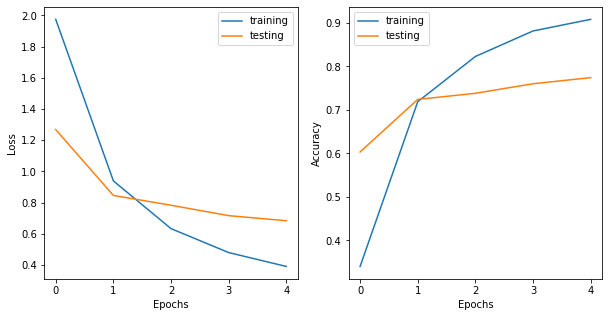

In [ ]:
# Plot loss curves of our resnet model
plot_loss_curves(history_resnet)

### Creating and testing EfficientNet B0 Tensorflow Hub feature extraction model

In [ ]:
# Create EfficientNetB0 feature extarctor model
efficientnet_model=create_model(model_url=efficient_url,
                                num_classes=train_data_10_percent.num_classes)

# Compile the model
efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"]
                        )

# Fit the model
efficientnet_history=efficientnet_model.fit(train_data_10_percent,
                                            epochs=5,
                                            steps_per_epoch=len(train_data_10_percent),
                                            validation_data=test_data_10_percent,
                                            validation_steps=len(test_data_10_percent),
                                            callbacks=[create_tensorboard_callback(dir_name='tf_hub',experiment_name="Efficient_netB0")])

Saving Tensorboard log files to: tf_hub/Efficient_netB0/20220624-173745
Epoch 1/5
24/24 [==============================] - 27s 750ms/step - loss: 1.8378 - accuracy: 0.4280 - val_loss: 1.2768 - val_accuracy: 0.7280
Epoch 2/5
24/24 [==============================] - 16s 667ms/step - loss: 1.0509 - accuracy: 0.7707 - val_loss: 0.8612 - val_accuracy: 0.8180
Epoch 3/5
24/24 [==============================] - 16s 667ms/step - loss: 0.7528 - accuracy: 0.8253 - val_loss: 0.6909 - val_accuracy: 0.8456
Epoch 4/5
24/24 [==============================] - 16s 667ms/step - loss: 0.6045 - accuracy: 0.8693 - val_loss: 0.6057 - val_accuracy: 0.8552
Epoch 5/5
24/24 [==============================] - 15s 658ms/step - loss: 0.5086 - accuracy: 0.8973 - val_loss: 0.5511 - val_accuracy: 0.8576


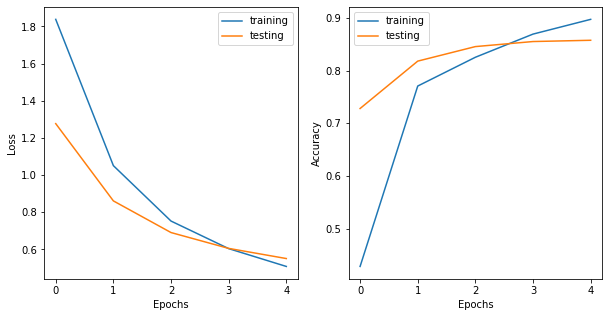

In [ ]:
plot_loss_curves(efficientnet_history)

## Different types of transfer learning

* "As is" transfer learning - using an existing model with no changes whatsoever (e,g, using ImageNet model on 1000 ImageNet classes).
* "Feature extraction" transfer learning - use the prelearned patterns of an existing model (e.g. What we did)
* "Fine-tuning" - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers)

## Comparing our models using TensorBoard

> 🔑**Note:** when you upload things to TensorBoard.dev, your experiments are public. So if you're running private experiments (things you don't want others to see) do not upload them to TensorBoard.dev

In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tf_hub/ --name "EfficientNetB0 vs. ResNet50V2" --description "Comparing two differnt TF hub models" --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tf_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=7L7VN8wUh26C1B4wfuG6DJOa4ZSvti&prompt=consent&access_type=offline
Ent

Our TensorBoard experiments are uploaed on https://tensorboard.dev/experiment/b1L8WANGS92wxaZiRWQ5Bw/